## IO - Detekcja raka skóry (czerniaka) na podstawie metod radiomicznych z użyciem metod uczenia maszynowego

In [1]:
!python -m pip install pyradiomics
!python -m pip install SimpleITK

### Przygotowanie zbioru danych

In [2]:
from __future__ import print_function
import SimpleITK as sitk
import sys
import radiomics
from radiomics import firstorder
from radiomics import featureextractor  # This module is used for interaction with pyradiomics
import six
import os  # needed navigate the system to get the input data
import numpy as np

C:\Users\Admin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# assign directory
directory1 = 'train'
directory2 = 'train_mask'
 
# iterate over files in
# that directory
for filename in os.listdir(directory1):
    f = os.path.join(directory1, filename)
    # checking if it is a file
    if os.path.isfile(f):
        colorimage = sitk.ReadImage(f)
        image = sitk.VectorMagnitude(colorimage)
        sitk.WriteImage(image, "train_nrrd/" + filename.split(".jpg")[0] + ".nrrd")

for filename in os.listdir(directory2):
    f = os.path.join(directory2, filename)
    # checking if it is a file
    if os.path.isfile(f):
        mask = sitk.ReadImage(f)
        sitk.WriteImage(mask, "train_nrrd_mask/" + filename.split(".png")[0] + ".nrrd")


### Wyznaczenie cech radiomicznych

In [ ]:
#it takes about 20 mins

directory = 'train_nrrd'
extractor = featureextractor.RadiomicsFeatureExtractor()
array_of_x = np.array([])
array_of_y = np.array([])

csv = np.genfromtxt ('train_gt.csv', delimiter=",")

it = 0
for filename in os.listdir(directory):
    it = it + 1
    curr_csv_row = csv[it]
    if curr_csv_row[1] == 1 or curr_csv_row[2] == 1:
        if curr_csv_row[1] == 1:
            array_of_y = np.append(array_of_y, 1)
        else:
            array_of_y = np.append(array_of_y, 0)
        list_of_res = []
        image_file = os.path.join(directory, filename)
        mask_file = os.path.join(directory + "_mask", filename.split(".nrrd")[0] + "_segmentation.nrrd")
        result = extractor.execute(image_file, mask_file, label = 255)
        list_of_result = list(result.values())
        list_of_result = list_of_result [22:]
        array_of_result = np.array(list_of_result)
        array_of_x = np.append(array_of_x, np.array(array_of_result), axis = 0)
        


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


KeyboardInterrupt: 

### Predykcja na podstawie metod uczenia maszynoweg

In [ ]:
import pandas
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

array_of_x = np.reshape(array_of_x, (7818,93))

X_train, X_test, y_train, y_test = train_test_split(array_of_x, array_of_y, test_size=0.1)

dtree = DecisionTreeClassifier().fit(X_train, y_train)

svm = svm.SVC().fit(X_train, y_train)

bag = BaggingClassifier().fit(X_train, y_train)

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)

knn = KNeighborsClassifier().fit(X_train, y_train)

nnet = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(1000, 20), random_state=1).fit(X_train, y_train)

print("Decision tree: ", 100* dtree.score(X_test, y_test) ,"%")
print("SVM: ", 100* svm.score(X_test, y_test) ,"%")
print("Bootstrap aggregation: ", 100* bag.score(X_test, y_test) ,"%")
print("Gradient boosting: ", 100* gb.score(X_test, y_test) ,"%")
print("K-nearest neighbors: ", 100* knn.score(X_test, y_test) ,"%")
print("Neural network: ", 100* nnet.score(X_test, y_test) ,"%")

1
2
3
4
5
6
Decision tree:  81.71355498721228 %
SVM:  87.0843989769821 %
Bootstrap aggregation:  88.61892583120205 %
Gradient boosting:  87.85166240409207 %
K-nearest neighbors:  84.91048593350384 %
Neural network:  87.0843989769821 %


### Ważność cech

Elapsed time to compute the importances: 0.011 seconds


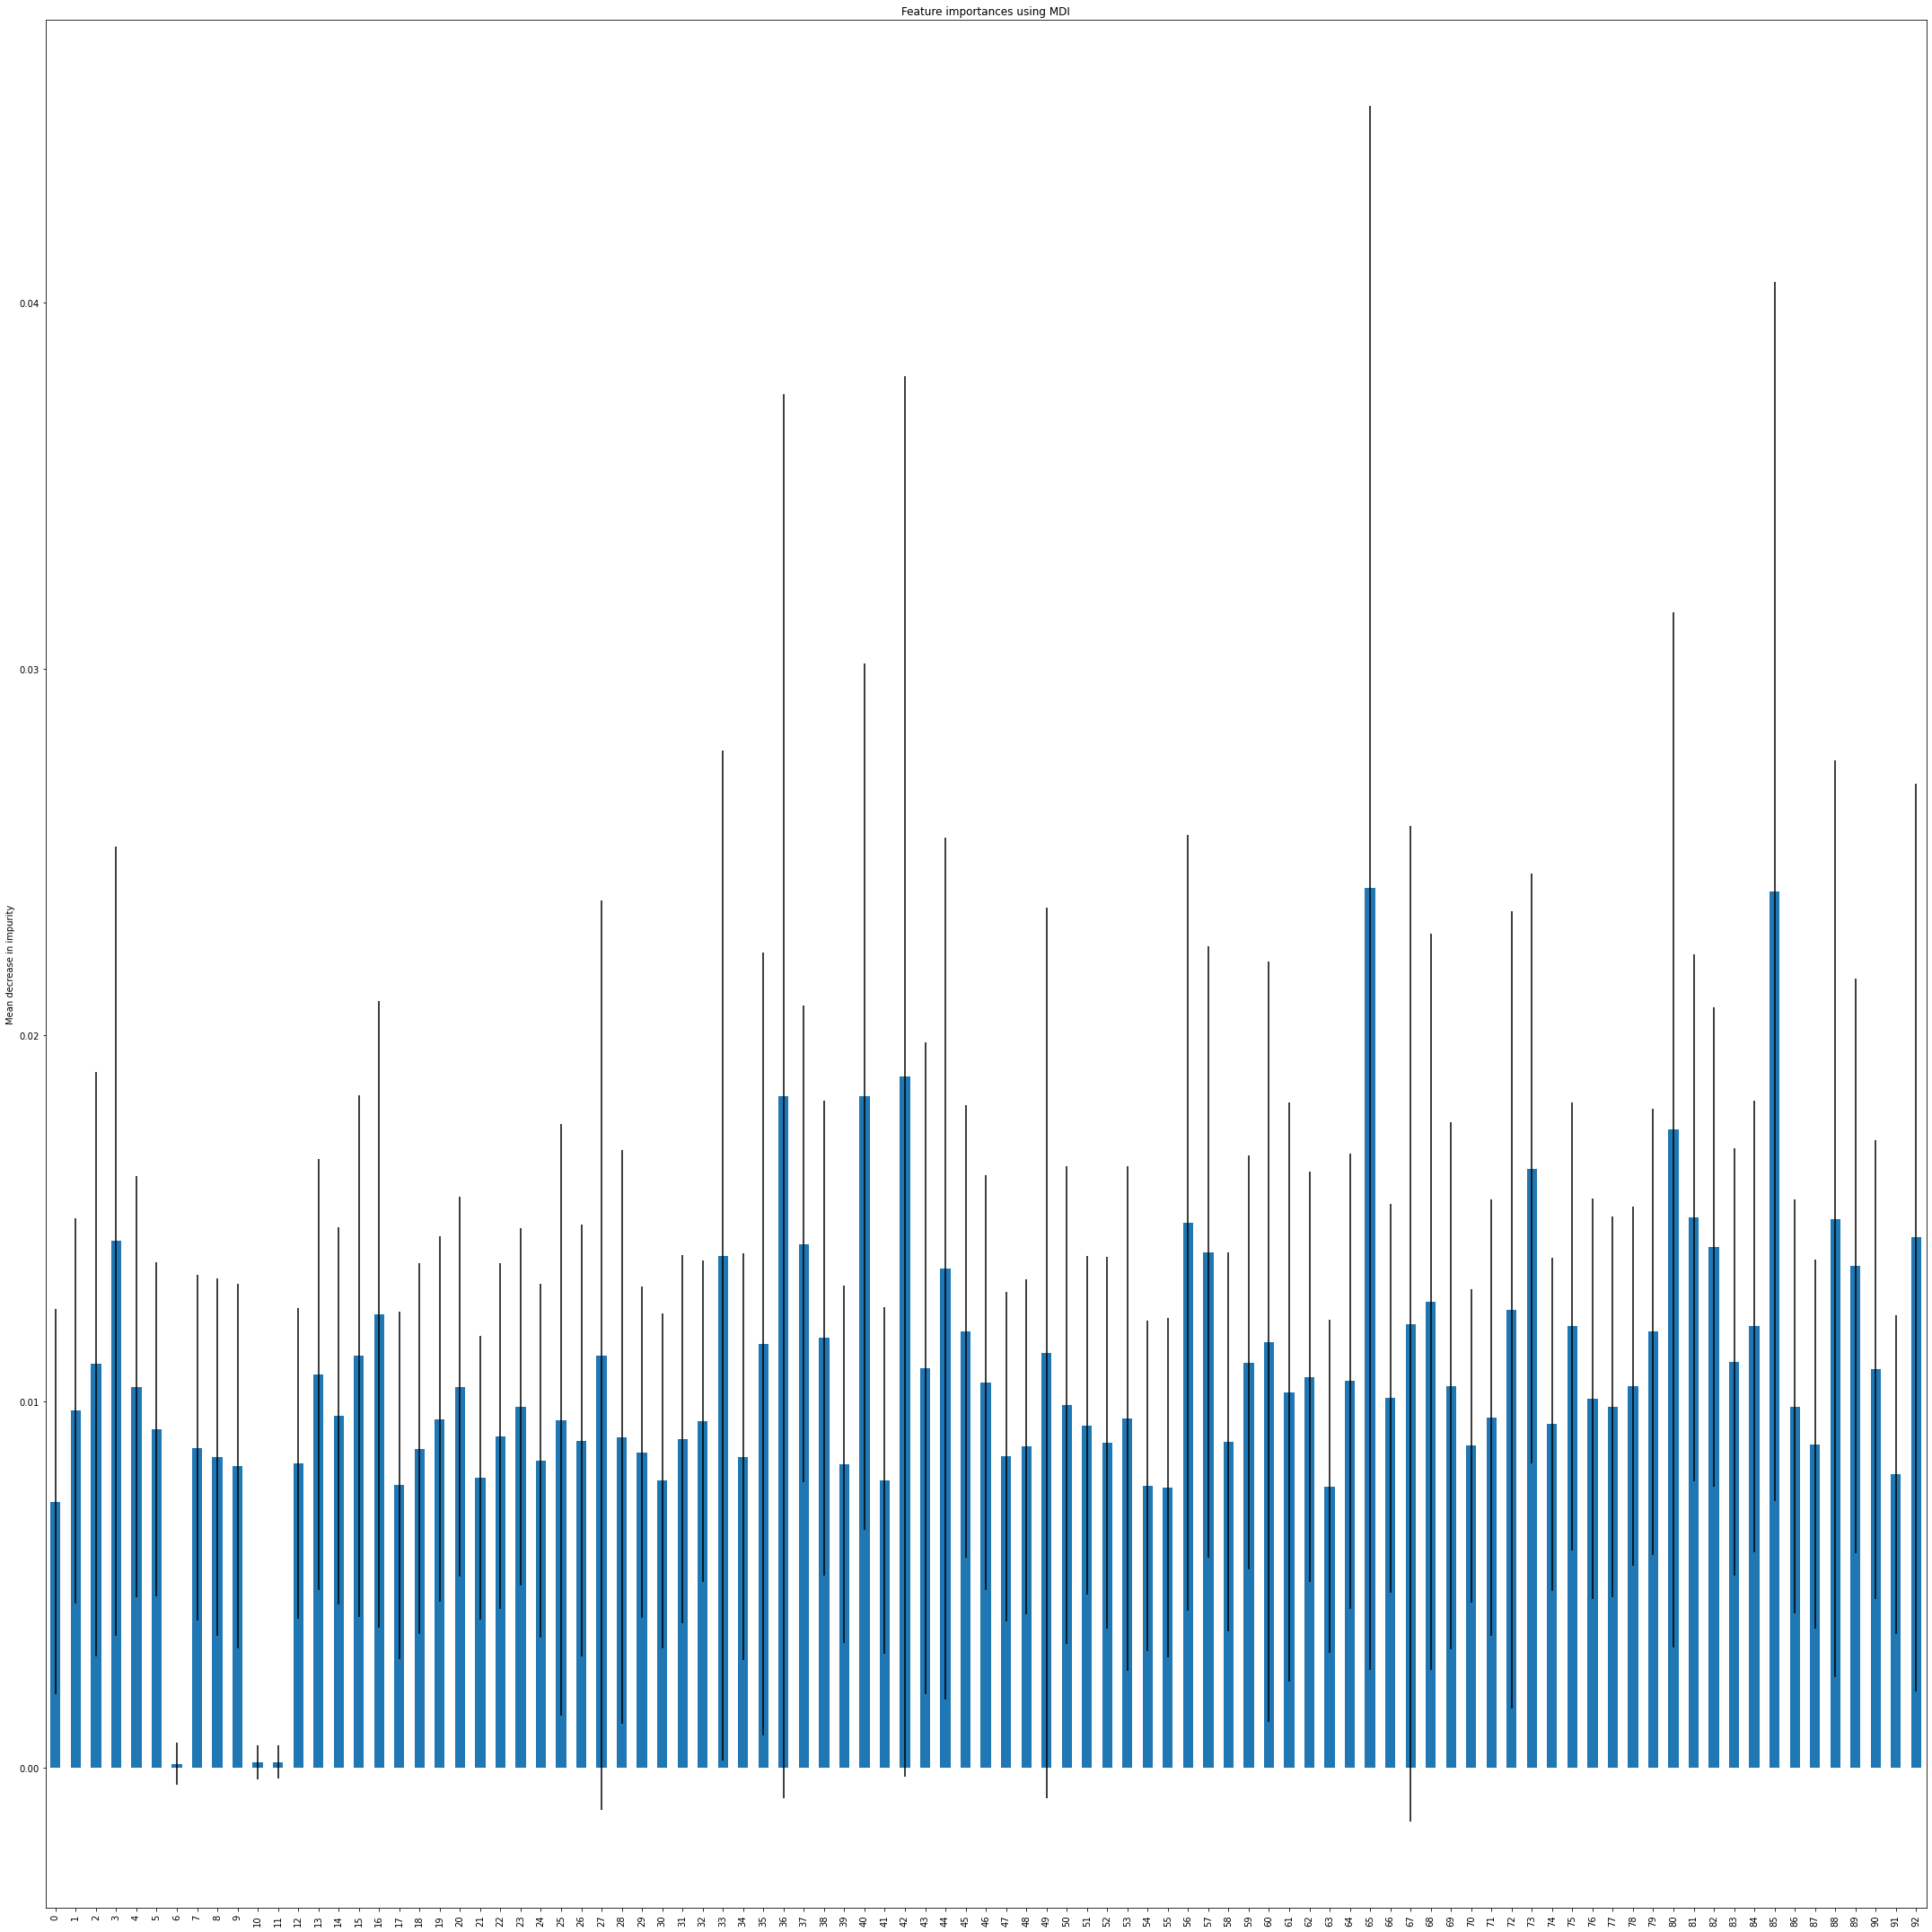

In [ ]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import time

forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)
feature_names = list(range(0, 93))

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(30, 30))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

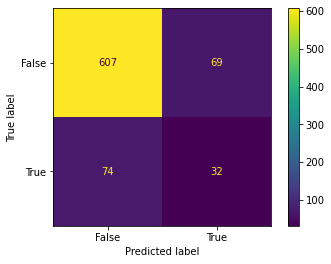

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(dtree.predict(X_test), y_test)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 